In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('heart_attack_risk_prediction_1.csv')
data

,Age,Gender,Diabetes,Hypertension,Obesity,Smoking,Alcohol_Consumption,Physical_Activity,Diet_Score,Cholesterol_Level,Triglyceride_Level,Systolic_BP,Diastolic_BP,Air_Pollution_Exposure,Family_History,Stress_Level,Heart_Attack_History,Heart_Attack_Risk
0,42,0,0,0,1,1,0,0,9,248,125,93,119,1,0,4,0,0
1,26,1,0,0,0,0,1,1,4,272,51,134,115,0,0,7,0,0
2,78,1,0,0,1,0,0,1,6,268,213,104,117,0,1,10,0,0
3,58,1,1,0,1,0,0,1,9,224,250,91,65,0,0,1,1,0
4,22,1,0,0,0,0,0,1,5,277,129,141,109,0,0,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,20,0,0,0,0,1,0,1,6,160,238,133,74,1,1,10,0,0
9996,34,0,0,0,0,0,0,0,5,257,241,124,78,0,1,1,0,1
9997,76,1,0,0,0,0,0,0,2,205,69,151,98,1,0,1,1,0
9998,52,1,0,0,0,0,0,1,5,155,288,127,60,1,0,7,0,0


### Parallel Ensembles Using VotingClassifier

In [25]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import warnings

warnings.filterwarnings("ignore")  

X = data.drop(columns=['Heart_Attack_Risk'])
y = data['Heart_Attack_Risk']
X.shape, y.shape

# Example train-test split (assuming you have X and y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Columns to scale
cols_to_scale = ['Age', 'Diet_Score', 'Cholesterol_Level', 'Triglyceride_Level', 
                 'Systolic_BP', 'Diastolic_BP', 'Stress_Level']

from sklearn.compose import ColumnTransformer
# Define ColumnTransformer: scale only specified columns, rest pass-through
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), cols_to_scale)
    ],
    remainder='passthrough'  # keep other columns as-is
)

# Create pipeline with preprocessing + classifier
log_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42))
])

svc_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(probability=True, class_weight='balanced', random_state=42))
])



# Tree-based models (no scaling required)
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)

# Voting Classifier combining all models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('gb', gb_clf),
        ('ada', ada_clf),
        ('log', log_clf),
        ('svc', svc_clf)
    ],
    voting='soft',  # 'hard' for majority class label voting; 'soft' uses predicted probabilities
    weights=[1,2,2,1,1]    # we can adjust weights based on performance
)

# Train ensemble
voting_clf.fit(X_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_test)
y_proba = voting_clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Ensemble Voting Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Ensemble Voting Classifier Evaluation:
Accuracy: 0.699
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC Score: 0.5115974669149586

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      2098
           1       0.00      0.00      0.00       902

    accuracy                           0.70      3000
   macro avg       0.35      0.50      0.41      3000
weighted avg       0.49      0.70      0.58      3000



In [15]:
# Predictions
y_pred_train = voting_clf.predict(X_train)
y_proba_train = voting_clf.predict_proba(X_train)[:, 1]

# Evaluation
print("Ensemble Voting Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("Precision:", precision_score(y_train, y_pred_train))
print("Recall:", recall_score(y_train, y_pred_train))
print("F1 Score:", f1_score(y_train, y_pred_train))
print("ROC AUC Score:", roc_auc_score(y_train, y_proba_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))


Ensemble Voting Classifier Evaluation:
Accuracy: 0.703
Precision: 1.0
Recall: 0.012351543942992874
F1 Score: 0.024401689347724072
ROC AUC Score: 0.99998951860811

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      4895
           1       1.00      0.01      0.02      2105

    accuracy                           0.70      7000
   macro avg       0.85      0.51      0.42      7000
weighted avg       0.79      0.70      0.58      7000



In [ ]:
Ensemble Voting Classifier Evaluation:
Accuracy: 0.703
Precision: 1.0
Recall: 0.012351543942992874
F1 Score: 0.024401689347724072
ROC AUC Score: 0.99998951860811

Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      4895
           1       1.00      0.01      0.02      2105

    accuracy                           0.70      7000
   macro avg       0.85      0.51      0.42      7000
weighted avg       0.79      0.70      0.58      7000

**1) Is this a parallel or series ensembling?**

- This is parallel ensembling because all models are trained independently on the same dataset, and their predictions are combined at the end using a voting mechanism.

**2) Which models are trained first, and to which model the resultants are passed?**

- All five models (Random Forest, Gradient Boosting, AdaBoost, Logistic Regression, and SVC) are trained simultaneously on the training data.

- Once trained, each model makes predictions on the test data.

- The VotingClassifier then aggregates these predictions using soft voting, meaning it averages the predicted probabilities from all models to make the final decision.

**3) Step-by-step flow of model training:**

- Data Preprocessing:

    - Numerical features are scaled using StandardScaler within a ColumnTransformer.

    - Tree-based models (RF, GB, AdaBoost) do not require scaling, so they are trained directly.

- Model Training:

    - Logistic Regression and SVC are trained using the preprocessed data.

    - Random Forest, Gradient Boosting, and AdaBoost are trained on the raw data.

- Voting Mechanism:

    - Each model predicts probabilities for the test data.
    
    - The VotingClassifier averages these probabilities (soft voting).
    
    - The final prediction is based on the highest averaged probability.

### Custom Thresholding

In [23]:

# Set a custom threshold (try different values)
custom_thresh = 0.3

# Convert probabilities to class labels based on threshold
y_pred_custom = (y_proba >= custom_thresh).astype(int)

# Evaluate the new predictions
print("Custom Threshold Evaluation:")
print("Recall:", recall_score(y_test, y_pred_custom))
print("Precision:", precision_score(y_test, y_pred_custom))
print("F1 Score:", f1_score(y_test, y_pred_custom))


Custom Threshold Evaluation:
Recall: 0.9878048780487805
Precision: 0.3016249153689912
F1 Score: 0.46213692946058094


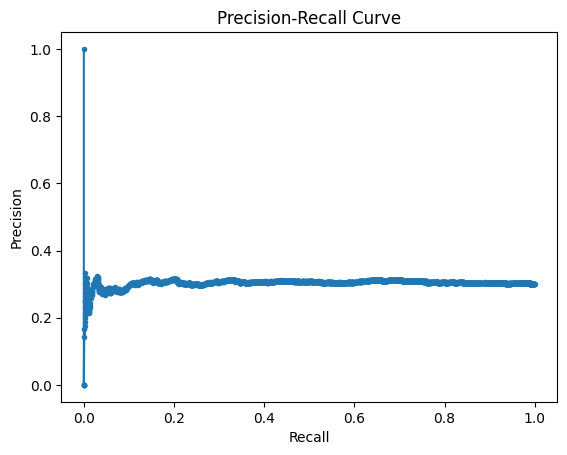

In [27]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


### Parallel Ensembles Using StackingClassifier

In [29]:
from sklearn.ensemble import StackingClassifier

# Define base estimators (same as before)
estimators = [
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('ada', ada_clf),
    ('log', log_clf),
    ('svc', svc_clf)
]

# Define the meta-model
meta_model = LogisticRegression(class_weight='balanced', random_state=42)

# Create stacking ensemble
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,  # Meta-model learns from base models' predictions
    cv=5,  # Cross-validation for robustness
    n_jobs=-1
)

# Train stacking classifier
stacking_clf.fit(X_train, y_train)

# Predictions
y_pred_stack = stacking_clf.predict(X_test)
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]

# Evaluation
print("Stacking Classifier Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))


Stacking Classifier Evaluation:
Accuracy: 0.501
Precision: 0.2891566265060241
Recall: 0.4523281596452328
F1 Score: 0.3527885862516213
ROC AUC Score: 0.4917358734641164

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.52      0.59      2098
           1       0.29      0.45      0.35       902

    accuracy                           0.50      3000
   macro avg       0.49      0.49      0.47      3000
weighted avg       0.57      0.50      0.52      3000

